In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ARIMA, SARIMAX
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')


In [283]:
df = pd.read_excel('./data/LME_westmetall_db.xlsx', index_col='date',parse_dates=['date']).drop('Unnamed: 0', axis=1)

---

### Copper

<AxesSubplot: xlabel='date'>

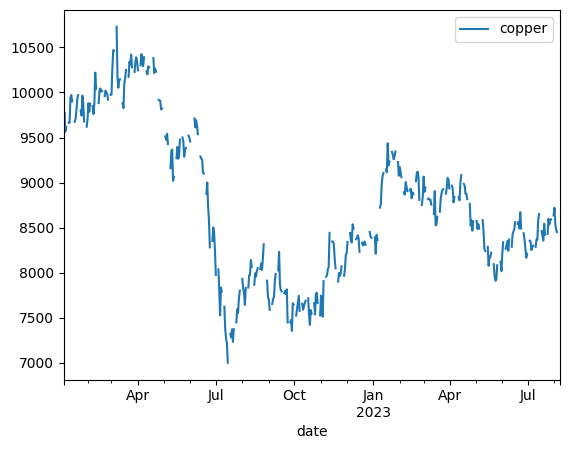

In [284]:
df_copper = pd.DataFrame(df['copper'], index= df.index)
df_copper = df_copper.asfreq('D') 
df_copper.plot()

Interpolation

In [285]:
df_copper['copper'] = df_copper['copper'].interpolate(method='linear')

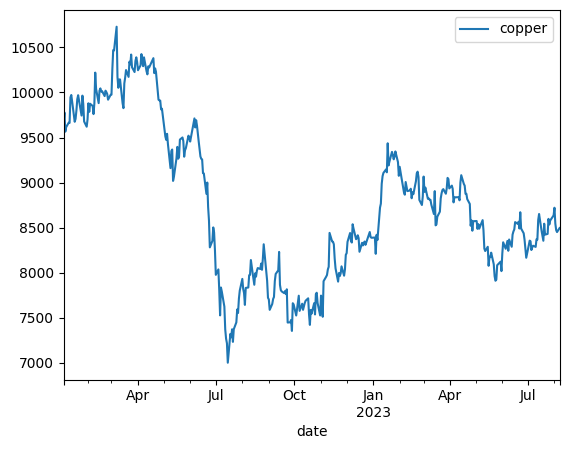

In [286]:
df_copper.plot()
plt.show()

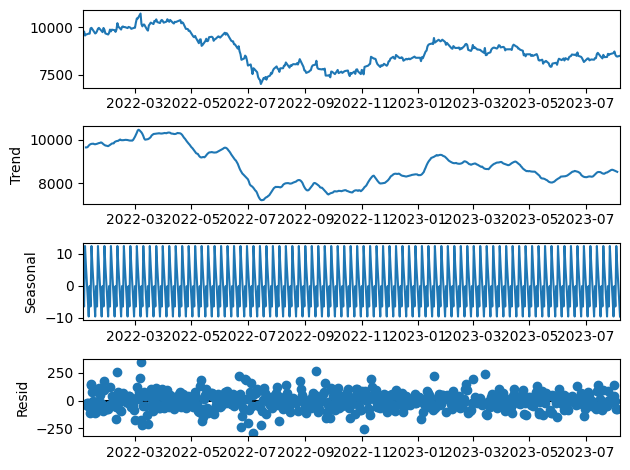

In [287]:
decompose = seasonal_decompose(df_copper)
decompose.plot()
plt.show()

<AxesSubplot: xlabel='date'>

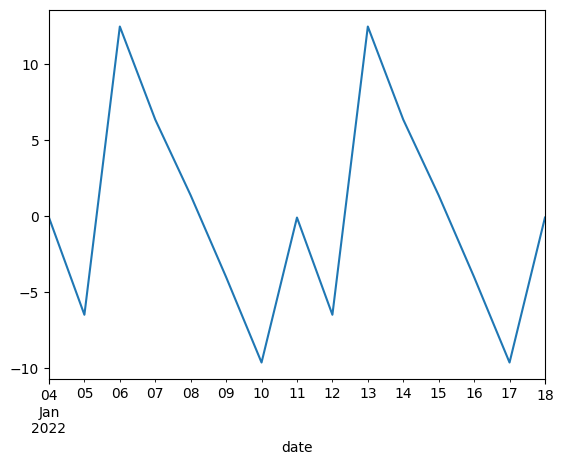

In [288]:
decompose.seasonal[:15].plot()

seasonal component = 7

---

Train/test split

In [289]:
train_df = df_copper[:-120]
test_df = df_copper[-120:]

MA prediction = baseline

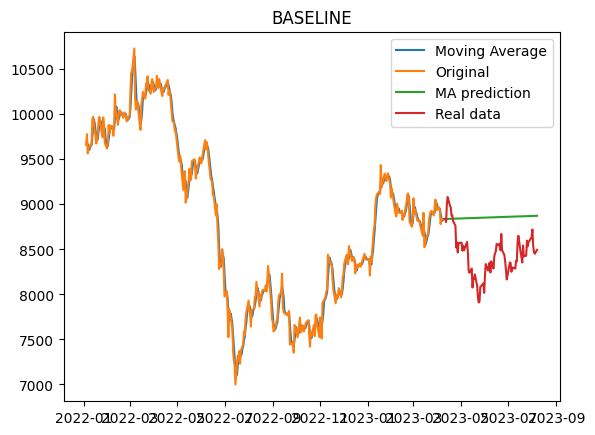

RMSE for MA: 472.9684231051695


In [290]:
# Moving average prediction
def ma_prediction(train_data, test_data=None, window_size=test_df.shape[0], pred_num=test_df.shape[0]):

    data_ma = train_data.rolling(window_size).mean()
    last_values = data_ma.tail(window_size).values
    prediction = np.array([last_values[-1] +
                           (last_values[-1] - last_values[-2]) * i for i in range(1, pred_num + 1)])
    prediction = pd.DataFrame(
        prediction, columns=test_data.columns, index=test_data.index)
    return data_ma, prediction


ma_model, ma_pred = ma_prediction(train_df, test_df, window_size=3)
plt.plot(ma_model, label='Moving Average')
plt.plot(train_df, label='Original')
plt.plot(ma_pred, label='MA prediction')
plt.plot(test_df, label='Real data')
plt.title('BASELINE')
plt.legend()
plt.show()
ma_rmse = np.sqrt(mean_squared_error(test_df, ma_pred))
print(f'RMSE for MA: {ma_rmse}')


In [291]:
ma_pred

,copper
date,
2023-04-10,8836.9
2023-04-11,8837.2
2023-04-12,8837.5
2023-04-13,8837.8
2023-04-14,8838.1
...,...
2023-08-03,8871.4
2023-08-04,8871.7
2023-08-05,8872.0


In [292]:
test_df

,copper
date,
2023-04-10,8837.200000
2023-04-11,8837.500000
2023-04-12,8803.000000
2023-04-13,9001.500000
2023-04-14,9082.000000
...,...
2023-08-03,8472.000000
2023-08-04,8450.500000
2023-08-05,8465.333333


Stationarity check

In [293]:
def stationary(data, p_value=0.05):
    stats = adfuller(data)
    if stats[1] > p_value:
        print('Not stationary')
    else:
        print('Stationary')


stationary(df_copper)


Not stationary


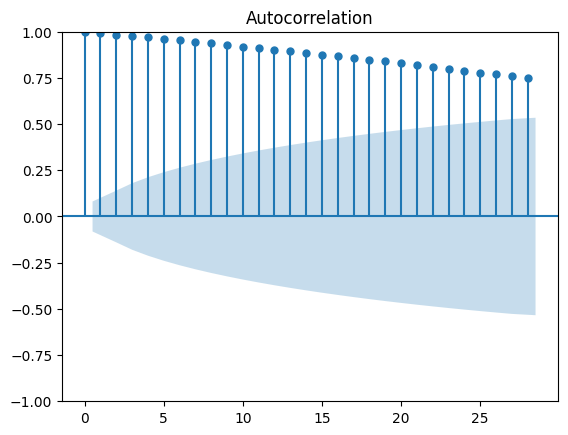

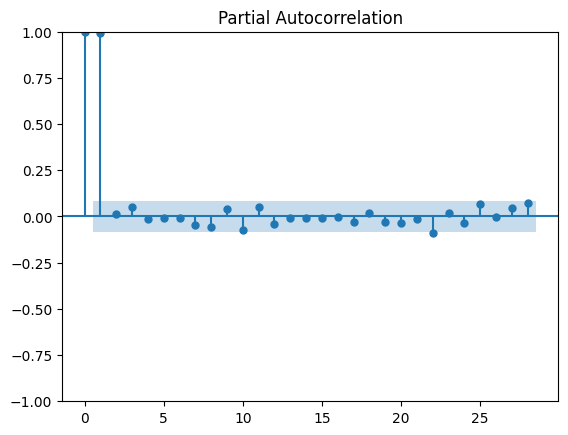

In [294]:
acf = plot_acf(df_copper)
plt.show()
pacf = plot_pacf(df_copper)
plt.show()

In [295]:
stationary(df_copper_diff_1 := df_copper.diff().dropna())

Stationary


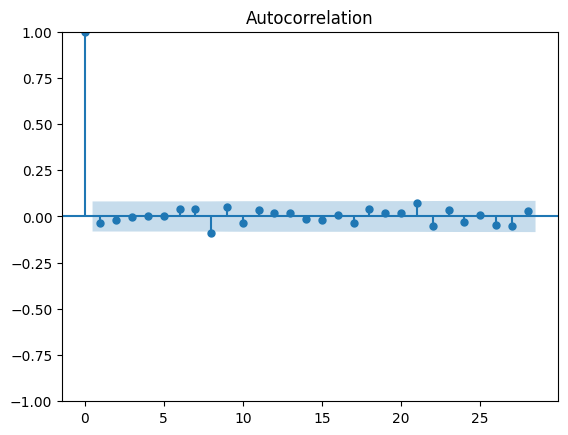

In [296]:
acf = plot_acf(df_copper_diff_1)
plt.show()

p = 1 (partial autocor), d = 1(number of differiantial), q = 8 (auto-correlation on diffseries)

In [297]:
p = 1
d = 1
q = 1

arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 copper   No. Observations:                  461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2800.605
Date:                Tue, 08 Aug 2023   AIC                           5607.210
Time:                        16:34:13   BIC                           5619.603
Sample:                    01-04-2022   HQIC                          5612.090
                         - 04-09-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3218      1.402      0.230      0.818      -2.425       3.069
ma.L1         -0.3526      1.388     -0.254      0.799      -3.072       2.367
sigma2      1.134e+04    483.520     23.458      0.000    1.04e+04    1.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               210.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.19
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [298]:
pred_df = pd.DataFrame(index=test_df.index)

pred_df["copper"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

forecast = arima_model_fit.get_forecast(len(test_df))
forecast_df = forecast.conf_int(alpha=0.05)


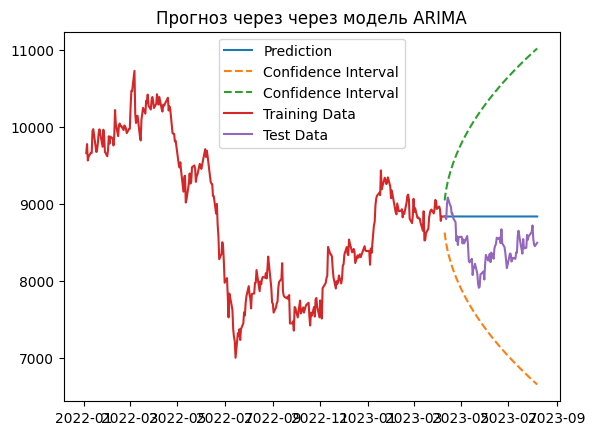

In [299]:
plt.plot(pred_df, label='Prediction')
plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
plt.plot(train_df, label='Training Data')
plt.plot(test_df, label='Test Data')
plt.title('Прогноз через через модель ARIMA')
plt.legend()
plt.show()


In [300]:
pred_df

,copper
date,
2023-04-10,8836.887540
2023-04-11,8836.883530
2023-04-12,8836.882239
2023-04-13,8836.881824
2023-04-14,8836.881690
...,...
2023-08-03,8836.881627
2023-08-04,8836.881627
2023-08-05,8836.881627


In [301]:
test_df

,copper
date,
2023-04-10,8837.200000
2023-04-11,8837.500000
2023-04-12,8803.000000
2023-04-13,9001.500000
2023-04-14,9082.000000
...,...
2023-08-03,8472.000000
2023-08-04,8450.500000
2023-08-05,8465.333333


autoarima

<bound method ARIMA.arparams of ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>


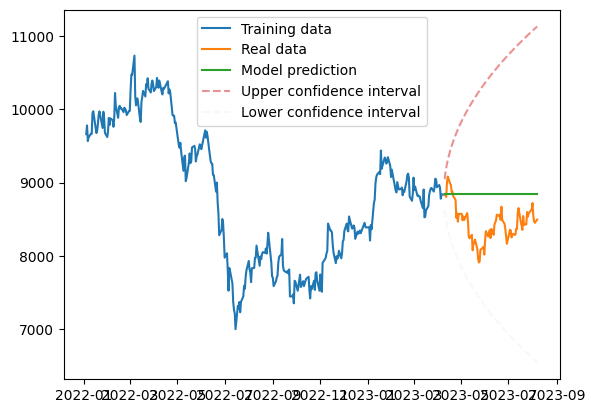

In [302]:
model_auto = pm.auto_arima(train_df)
forecast, conf_int = model_auto.predict(n_periods=test_df.shape[0], return_conf_int=True)

auto_rmse = np.sqrt(mean_squared_error(test_df, forecast))
print(model_auto.arparams)

conf_low = pd.DataFrame(conf_int.T[0], columns=[
                        'lower_bound'], index=test_df.index)
conf_high = pd.DataFrame(conf_int.T[1], columns=[
                         'upper_bound'], index=test_df.index)


plt.plot(train_df, label='Training data')
plt.plot(test_df, label='Real data')
plt.plot(forecast, label='Model prediction')
plt.plot(conf_high, linestyle="--",
         label='Upper confidence interval', alpha=0.5)
plt.plot(conf_low, linestyle="--", label='Lower confidence interval', alpha=0.05)
plt.legend()
plt.show()


In [303]:
test_df

,copper
date,
2023-04-10,8837.200000
2023-04-11,8837.500000
2023-04-12,8803.000000
2023-04-13,9001.500000
2023-04-14,9082.000000
...,...
2023-08-03,8472.000000
2023-08-04,8450.500000
2023-08-05,8465.333333


In [304]:
forecast

2023-04-10    8836.9
2023-04-11    8836.9
2023-04-12    8836.9
2023-04-13    8836.9
2023-04-14    8836.9
               ...  
2023-08-03    8836.9
2023-08-04    8836.9
2023-08-05    8836.9
2023-08-06    8836.9
2023-08-07    8836.9
Freq: D, Length: 120, dtype: float64

---

In [305]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=5859.171, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=5740.198, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=5860.068, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=5691.970, Time=0.23 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=5690.890, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=5740.128, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=5691.929, Time=0.16 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=5692.877, Time=0.37 sec

B

In [306]:
seas_model = SARIMAX(
    train_df["copper"].dropna(), order=(0, 1, 0), seasonal_order=(2, 1, 0, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16583D+00    |proj g|=  1.45096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   2.636D-06   6.166D+00
  F =   6.1658239726573862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            copper   No. Observations:                  461
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -2842.445
Date:                           Tue, 08 Aug 2023   AIC                           5690.890
Time:                                   16:34:19   BIC                           5703.251
Sample:                               01-04-2022   HQIC                          5695.759
                                    - 04-09-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.6414      0.041    -15.657      0.000      -0.722      -0.561
ar.S.L10      -0.3262      0.037     -8.900      0.000      -0.398      -0.254
sigma2      1.549e+04    718.361     21.567      0.000    1.41e+04    1.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                97.71
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.23
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [307]:
pred_df = pd.DataFrame(index=test_df.index)

pred_df["copper"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

In [308]:
pred_df

,copper
date,
2023-04-10,8744.943403
2023-04-11,8762.735556
2023-04-12,8785.020665
2023-04-13,8826.878662
2023-04-14,8811.235112
...,...
2023-08-03,7335.757517
2023-08-04,7364.768190
2023-08-05,7377.905035


In [309]:
test_df

,copper
date,
2023-04-10,8837.200000
2023-04-11,8837.500000
2023-04-12,8803.000000
2023-04-13,9001.500000
2023-04-14,9082.000000
...,...
2023-08-03,8472.000000
2023-08-04,8450.500000
2023-08-05,8465.333333
